In [1]:
#添加xgboost和seaborn的环境变量
import sys
sys.path.append('/Library/Python/2.7/site-packages/xgboost-0.6-py2.7.egg/')
sys.path.append('/usr/local/lib/python2.7/site-packages')
sys.path

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn import model_selection, preprocessing
color = sns.color_palette()

##设置默认编码
reload(sys)
sys.setdefaultencoding('utf8')


%matplotlib inline #IPython magic函数,图像嵌入notebook中

pd.options.mode.chained_assignment = None #配置链式赋值,不警告
pd.set_option('display.max_columns', 500) #最大显示列数设置


In [2]:
train_df = pd.read_csv('../data/train.csv')
train_df.head(8)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
5,6,2011-09-06,67,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,62,14,1,53,78,1,20,113,17,9100000
6,7,2011-09-08,25,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,81,16,3,38,80,1,27,127,8,5500000
7,8,2011-09-09,44,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,11,18,1,0,47,4,2000000


## 房价数据的散布图
从图中可以看出，房价的分布情况

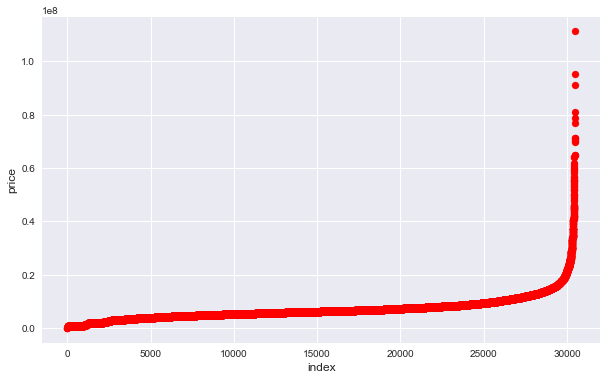

In [3]:
plt.figure(figsize=(10, 6)) #大小配置
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values), c='red')
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

## 房价频率分布图
图中可以看出房价大部分集中于 $0.8 * 10^8$ 左右满足高斯分布

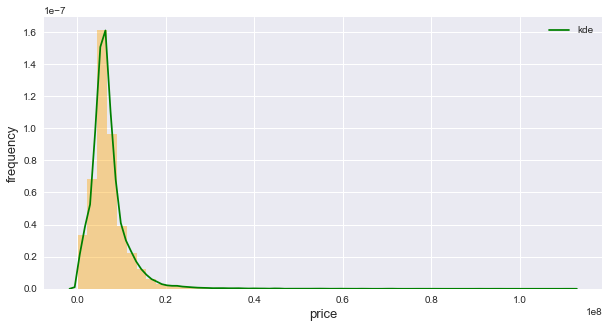

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(train_df.price_doc.values, bins=50, kde=True, color='orange',
            kde_kws={'color': 'green', 'label': 'kde'})
plt.xlabel('price', fontsize=13)
plt.ylabel('frequency', fontsize=13)
plt.show()

## 对数价格分布图
由于该竞赛采用的是RMSL评测函数，其形式:$$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log^{p_i}-log^{r_i})^2}$$
所以这里我们着重要优化的是预测房价与真实房价的对数值之差。
从图中可以看出，对数价格的分布更为的均匀，而不是过偏。

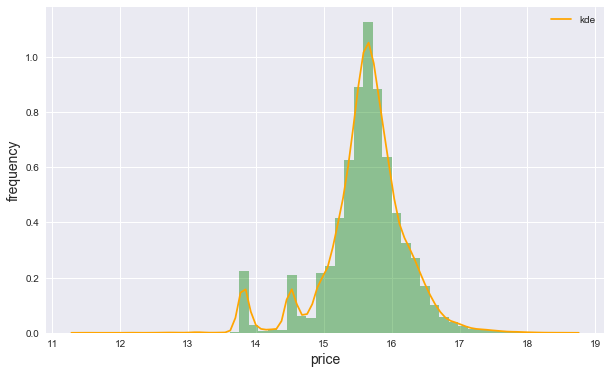

In [10]:
plt.figure(figsize=(10,6))
sns.distplot(np.log(train_df.price_doc.values), kde=True, color='green',
            kde_kws={'color': 'orange', 'label': 'kde'})
plt.xlabel('price', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

## 各个月份房价的中位数
平均值受最高最低有所影响，而中位数能良好反应当月房价的普遍情况，图中可以看出一定的月份差距与趋势。

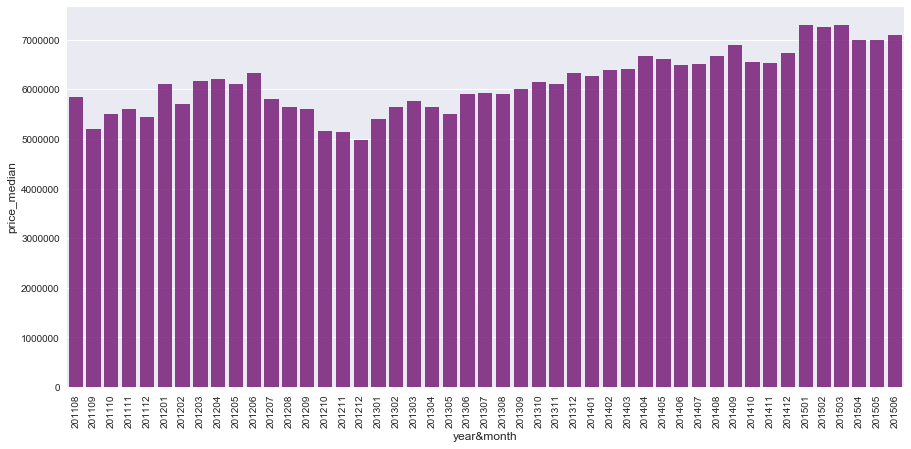

In [25]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[0:4] + x[5:7]) #时间格式转换
group_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index() #按年月时间分组并求中位数
plt.figure(figsize=(15,7))
sns.barplot(group_df.yearmonth.values, group_df.price_doc.values, alpha=0.8, color='purple')
plt.xlabel('year&month', fontsize=12)
plt.ylabel('price_median', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## 数据类型观察
可以发现大多数是数值类型。对于初步模型，我们可以只关注数值类型，而不关注其它类型。

In [37]:
train_df = pd.read_csv('../data/train.csv', parse_dates=['timestamp']) #读入的时候讲timestamp当做日期类型
dtype_df = train_df.dtypes.reset_index() #获取数据类型
dtype_df.columns = ["Count", "Data Type"]
dtype_df.groupby('Data Type').aggregate('count').reset_index()

,Data Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15
